# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA)

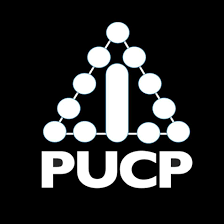

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe), Eng. Daniel Saromo

## Aprendizaje por refuerzo con Deep Q-networks - Entorno `CartPole-v1`

Esta es una implementacion de un agente Deep Q-learning que aprenda a balancear un péndulo invertido en el entorno `CartPole-v1` de OpenAI Gym.

Adaptado de  https://github.com/keon/deep-q-learning. 

Es necesario tener instalado: gym, tensorflow y keras. 

Descripción detallada del entorno: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L14

## Problema a resolver: Péndulo invertido

[Video](https://www.youtube.com/watch?v=XWhGjxdug0o)

<img src='https://www.gymlibrary.dev/_images/cart_pole.gif' width=200px>

El entorno `CartPole-v1` tiene un **modelamiento matemático** de las ecuaciones físicas que rigen un péndulo invertido ideal, con posición inicial apuntando hacia arriba. Este problema puede ser resuelto utilizando técnicas de **ingeniería de control**. En esta sesión, vamos a utilizar Deep Reinforcement Learning. El objetivo del agente que entrenaremos, es lograr que se mantenga la posición vertical del péndulo subactuado virtual. Se podría hacer que el agente aprenda a elevarlo, cuando la posición inicial del péndulo es apuntando hacia abajo.


[Swing-up and balancing control of an inverted pendulum mechanism](https://www.youtube.com/watch?v=XWhGjxdug0o) ;)

## Empecemos

### Clase <b>DQNAgent</b>

Esta es la clase que implementa el agente Double Deep Q-lerrning. Es una implementacion general, pudiendo ser usado en diferentes entornos de gym u otros. El constructor recibe las dimensiones del estado y la dimesion del vector de acciones posibles 

In [1]:
!pip install gym

In [2]:
import random
import gym
import numpy as np

from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size      # tamaño de un estado (numero de atributos que representan un estado)
        self.action_size = action_size    # tamaño del vector de acciones 
        self.memory = deque(maxlen=5000)  # define la memoria del agente (5000 registros como maximo)
        self.gamma = 0.98                 # discount rate
        self.learning_rate = 0.001        # taza de aprendizaje 
        
        self.epsilon = 1.0               # factor de exploration inicial
        self.epsilon_min = 0.01          # factor de exploration minimo
        self.epsilon_decay = 0.995       # factor de decaimiento del factor de exploracion
        self.model = self._build_model() # construye el modelo neuronal a entrenar 

    def _build_model(self):
        # Define y compila un modelo de red neuronal de 3 capas: state_size entradas X 20 neuronas X 20 neuronas x action_size neuronas de salida
        model = Sequential()   # Informa que las capas que se van agregar son secuenciales
        model.add(Dense(20, input_dim=self.state_size, activation='relu')) # 1ra capa de 20 neuronas, cada neurona recibe state_size entradas (4 para CartPole), activacion relu
        model.add(Dense(15, activation='relu')) # 2da capa de 15 neuronas, funcion de activacion relu
        model.add(Dense(self.action_size, activation='linear')) # 3ra capa (salida) de action_size neuronas (2 para CartPole)
       
        model.compile(loss='mse', optimizer = Adam(learning_rate=self.learning_rate)) # la funcion de perdida es el error cuadratico medio (mse)
        return model

    # metodo para guardar una transicion del agente (experiencia): (estado, accion, reward resultante, nuevo estado, done)
    # done es un flag que indica que el entorno cayo en un estado terminal
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))

    # retorna una accion.  
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:  # retorna una accion aleatoria con probabilidad self.epsilon
            return random.randrange(self.action_size)
        action_values = self.model.predict(state, verbose=0) # obtiene los q valores predichos por el modelo para cada accion
        return np.argmax(action_values[0])  # retorna la accion con el maximo q-valor predicho
    
    # retorna una accion.  
    def get_action_on_test(self, state):
        action_values = self.model.predict(state, verbose=0) # obtiene los q valores predichos por el modelo para cada accion
        return np.argmax(action_values[0])  # retorna la accion con el maximo q-valor predicho    

    # metodo para actualizar los pesos de model con una muestra (minibatch) de la memoria de experiencias de tamaño batch_size
    def replay(self, batch_size): 
        # obtiene una muestra de su memoria de experiencias
        minibatch = random.sample(self.memory, batch_size) 
        
        # Obtiene arrays de  states, accions, rewards, next_estates  del minibatch
        states = np.array([i[0] for i in minibatch])    
        actions = np.array([i[1] for i in minibatch])   
        rewards = np.array([i[2] for i in minibatch])   
        next_states = np.array([i[3] for i in minibatch]) 
        dones = np.array([i[4] for i in minibatch])       
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        
        # Calcula el target Q-value para la accion ejecutada en cada experiencia del batch 
        Qvals_next_states = self.model.predict_on_batch(next_states)  # predice Qvals de next_state con el modelo target
        Targets_actions = rewards + self.gamma*(np.amax(Qvals_next_states, axis=1))*(1-dones) # si es terminal -> Target = reward
        
        # Construye el target completo de Q-values para los states de cada experiencia del batch
        Targets = self.model.predict_on_batch(states)  # los target Q-values son los que predice el modelo actual, salvo el correspondiente a la accion tomada
        ind = np.array([i for i in range(batch_size)])
        Targets[[ind], [actions]] = Targets_actions   # actualiza el target Q-value de la accion ejecutada  
        
        # Ajusta el modelo  con pares  [states, Targets] del minibatch
        self.model.fit(states, Targets, epochs=1, verbose=0)

        # si no esta en el valor minimo del factor de exploracion -> hace un decaimiento del factor de exploracion
        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


### Familiarización con el entorno

[`CartPole-v1`](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L14)

In [3]:
env = gym.make('CartPole-v1')   # carga el modelo CartPole de gym
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)  # instancia el agente deep q-learning

In [4]:
state_size

4

In [5]:
action_size

2

In [6]:
state = env.reset()     # resetea el entorno
print("Initial State: ", state)

Initial State:  [0.01550311 0.03427658 0.03243146 0.01243252]


In [7]:
action = agent.get_action(state)   # obtiene una accion del agente
action

1

In [8]:
#next_state, reward, done, truncated, extraInfo = env.step(action)  # ejecuta action en el entorno y obtiene: nuevo estado, reward y flag done (si es estado terminal)
next_state, reward, done, extraInfo  = env.step(action)  # ejecuta action en el entorno y obtiene: nuevo estado, reward y flag done (si es estado terminal)
print("New State: ", next_state)
next_state, reward, done, extraInfo

New State:  [ 0.01618864  0.22891877  0.03268011 -0.26984407]


(array([ 0.01618864,  0.22891877,  0.03268011, -0.26984407]), 1.0, False, {})

In [9]:
env.close()

### Ejecutando el agente en el entorno CartPole

 

Definiremos el valor de `score` como la suma de `reward`s acumulados a través de los episodios.

In [10]:
done = False
batch_size = 64    # tamaño del batch con el que se re-entrena el modelo neuronal
EPISODES = 150      # numero de episodios

env = gym.make('CartPole-v1')   # carga el modelo Cartpole de gym
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)  # instancia el agente deep q-learning

score_list = []     # lista para guardar la evolucion del score
epsilon_list = []

for e in range(EPISODES):   # por cada episodio
    state = env.reset()     # resetea el entorno. Devuelve Tuple[ObsType, dict]
    state = np.reshape(state, [1, state_size]) #se hace reshape del state para ser un vector de entrada para la red neuronal
    score = 0
    for step in range(250):   # se prueba el agente hasta 300 pasos, sale de este loop cuando se cae en estado terminal (se cayo el pendulo)  
        #env.render()  # renderiza el entorno (por ahora no activarlo, porque de forma nativa, el renderizado no funciona en colab)
        action = agent.get_action(state)   # obtiene una accion del agente
        #next_state, reward, done, truncated, _ = env.step(action)  # ejecuta action en el entorno y obtiene: nuevo estado, reward y flag done (si es estado terminal)
        next_state, reward, done, _ = env.step(action)  # ejecuta action en el entorno y obtiene: nuevo estado, reward y flag done (si es estado terminal)
        reward = reward if not done else -10  # si es estado terminal el reward es -10
        next_state = np.reshape(next_state, [1, state_size]) # se hace reshape del state para ser un vector de entrada para la red neuronal
        
        agent.remember(state, action, reward, next_state, done) # almacena esta experiencia en la memoria del agente
        state = next_state   # actualiza el estado actual al nuevo estado
        score += reward
        
        if len(agent.memory) > batch_size:  # si hay suficiente experiencias en memoria del agente
             if step % 5 == 0:   # hace replay cada 5 steps
                agent.replay(batch_size)
        
        if done:  # si es estado terminal, imprime resultados del trial. El escore del trial es el numero de pasos que logro ejecutar el agente
            #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, step, agent.epsilon))
            break
    
    print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, step, agent.epsilon))
          
    score_list.append(score)   
    epsilon_list.append(agent.epsilon)
        
env.close()

episode: 0/150, score: 11, e: 1.0
episode: 1/150, score: 24, e: 1.0
episode: 2/150, score: 12, e: 1.0
episode: 3/150, score: 22, e: 0.99
episode: 4/150, score: 11, e: 0.98
episode: 5/150, score: 15, e: 0.96
episode: 6/150, score: 21, e: 0.93
episode: 7/150, score: 43, e: 0.89
episode: 8/150, score: 32, e: 0.86
episode: 9/150, score: 10, e: 0.85
episode: 10/150, score: 46, e: 0.81
episode: 11/150, score: 19, e: 0.79
episode: 12/150, score: 24, e: 0.77
episode: 13/150, score: 31, e: 0.74
episode: 14/150, score: 24, e: 0.73
episode: 15/150, score: 10, e: 0.71
episode: 16/150, score: 21, e: 0.7
episode: 17/150, score: 8, e: 0.69
episode: 18/150, score: 11, e: 0.68
episode: 19/150, score: 13, e: 0.67
episode: 20/150, score: 12, e: 0.66
episode: 21/150, score: 50, e: 0.62
episode: 22/150, score: 9, e: 0.62
episode: 23/150, score: 24, e: 0.6
episode: 24/150, score: 15, e: 0.59
episode: 25/150, score: 11, e: 0.58
episode: 26/150, score: 11, e: 0.57
episode: 27/150, score: 14, e: 0.56
episode: 

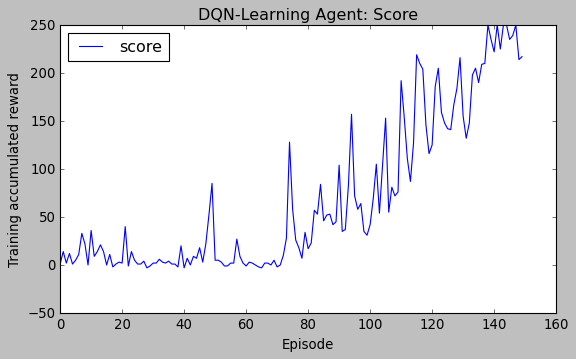

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#x = range(train_episodes)

mpl.style.use('classic')

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.set_title('DQN-Learning Agent: Score')
ax.set_xlabel('Episode')
#ax.set_xlim(-1000,20000)
ax.set_ylabel('Training accumulated reward')
ax.plot(score_list,'-', label='score')
ax.legend(loc='best')

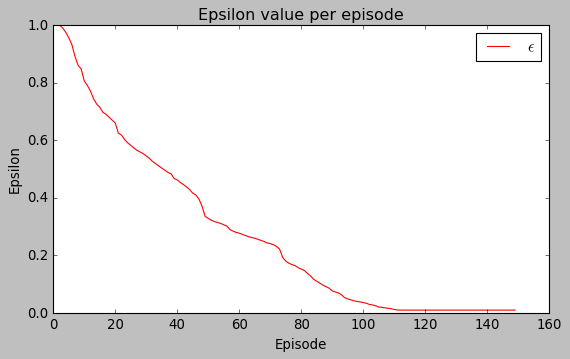

In [12]:
fig, ax = plt.subplots(figsize=(8, 4.5))

ax.set_title('Epsilon value per episode')
ax.set_xlabel('Episode')
#ax.set_xlim(-1000,20000)
ax.set_ylabel(r'Epsilon')
ax.plot(epsilon_list,'-', color='r', label=r'$\epsilon$')
ax.legend(loc='best')

### Funcion para probar el agente entrenado  en el entorno CartPole

play_CartPole()  no realiza entrenamiento, solo actua en el ambiente de acuerdo a su modelo aprendido previamente
 

In [13]:
def play_CartPole(agent, trials = 1):
    env = gym.make('CartPole-v1')
    #env = wrap_env(env)
    scores = []
    for trial in range(trials):
        score = 0
        game_memory = []
        #state = []
        
        state = env.reset()     # resetea el entorno
        #state = np.reshape(state[0], [1, state_size]) # se hace un res
        state = np.reshape(state, [1, state_size]) # se hace un res
        
        for step in range(500): # en cada trial ejecuta 500 steps
            env.render()

            #action = env.action_space.sample()
            #action = agent.get_action(state)   # obtiene una accion del agente
            action = agent.get_action_on_test(state)   # obtiene una accion del agente

            #next_state, reward, done, truncated, _ = env.step(action) # corre el entorno un step ejecutando la accion inferida
            next_state, reward, done, _ = env.step(action) # corre el entorno un step ejecutando la accion inferida
            next_state = np.reshape(next_state, [1, state_size])

            score += reward   # acumula el reward (reward=1 en cualquier estado no terminal)
            state = next_state
            game_memory.append([next_state, action])
            if done: 
                print("Play {}/{}, score: {}".format(trial, trials, score))
                break
        scores.append(score)
    env.close()
 
    print("Score medio = {}".format(sum(scores) /float(trials)) )
    

In [14]:
def play_CartPole_random(trials = 1):
    env = gym.make('CartPole-v1')
    #env = wrap_env(env)
    scores = []
    for trial in range(trials):
        score = 0
        game_memory = []
        state = []
        env.reset()
        for step in range(500): # en cada trial ejecuta 500 steps
            env.render()

            action = env.action_space.sample()  # pick a random action

            #next_state, reward, done, truncated, _ = env.step(action) # corre el entorno un step ejecutando la accion inferida
            next_state, reward, done, _ = env.step(action) # corre el entorno un step ejecutando la accion inferida
            
            score += reward   # acumula el reward (reward=1 en cualquier estado no terminal)
            state = next_state
            game_memory.append([next_state, action])
            if done: 
                print("Play {}/{}, score: {}".format(trial, trials, score))
                break
        scores.append(score)
    env.close()
 
    print("Score medio = {}".format(sum(scores) /float(trials)) )
    

In [20]:
# prueba el agente 5 trials del entorno
play_CartPole_random(5) #el video solo muestra la ejecución del último trial

Play 0/5, score: 10.0
Play 1/5, score: 81.0
Play 2/5, score: 16.0
Play 3/5, score: 47.0
Play 4/5, score: 18.0
Score medio = 34.4


In [21]:
# prueba el agente 5 trials del entorno
play_CartPole(agent,5)  #el video solo muestra la ejecución del último trial

Play 0/5, score: 249.0
Play 1/5, score: 229.0
Play 2/5, score: 259.0
Play 3/5, score: 216.0
Play 4/5, score: 245.0
Score medio = 239.6
